In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from particle import Particle


In [2]:
T_bdt_vars = [
    "nc_delta_score",
    "nc_pio_score",
    "numu_cc_flag",
    "shw_sp_n_20mev_showers",
    "shw_sp_n_20br1_showers",
    "single_photon_numu_score",
    "single_photon_other_score",
    "single_photon_ncpi0_score",
    "single_photon_nue_score",
]

T_eval_vars = [
    "run",
    "subrun",
    "event",
    "match_isFC",
    "truth_nuEnergy",
    "truth_nuPdg",
    "truth_isCC",
    "match_completeness_energy",
    "truth_energyInside",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "weight_cv",
    "weight_spline",
]

T_kine_vars = [
    "kine_reco_Enu",
    "kine_energy_particle",
    "kine_particle_type",
]

T_pf_vars = [
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",

    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]


In [3]:
f = uproot.open("/Users/leehagaman/uboone_python/epem_gamma_consistency/erin_rootfiles/checkout_ncpi0_run3_sp.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
df = pd.DataFrame(vars)
df["file"] = "nu_overlay"
print(f"loaded nc_pi0_overlay_run3 file, {len(df)} events")




loaded nc_pi0_overlay_run3 file, 47179 events


In [4]:
proton_nums = []
other_track_nums = []
energy_lists = df["kine_energy_particle"].to_numpy()
pdg_lists = df["kine_particle_type"].to_numpy()
for i in tqdm(range(df.shape[0])):
    proton_num = 0
    other_track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for i in range(len(energy_list)):
        if abs(pdg_list[i]) == 2212:
            if energy_list[i] > 35:
                proton_num += 1
        if abs(pdg_list[i]) == 13 or abs(pdg_list[i]) == 211: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            if energy_list[i] > 10.:
                other_track_num += 1
    proton_nums.append(proton_num)
    other_track_nums.append(other_track_num)
df["WC_reco_num_protons"] = proton_nums
df["WC_reco_num_other_tracks"] = other_track_nums

df["frac_cluster_completeness"] = df["match_completeness_energy"] / df["truth_energyInside"]


  0%|          | 0/47179 [00:00<?, ?it/s]

In [5]:
leading_photon_energies = []
leading_photon_conversion_xs = []
leading_photon_conversion_ys = []
leading_photon_conversion_zs = []
subleading_photon_energies = []
subleading_photon_conversion_xs = []
subleading_photon_conversion_ys = []
subleading_photon_conversion_zs = []

truth_pdgs = df["truth_pdg"].to_numpy()
truth_mothers = df["truth_mother"].to_numpy()
truth_startMomentums = df["truth_startMomentum"].to_numpy()
truth_startXYZTs = df["truth_startXYZT"].to_numpy()
truth_endXYZTs = df["truth_endXYZT"].to_numpy()
truth_ids = df["truth_id"].to_numpy()
for i in tqdm(range(df.shape[0])):

    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    truth_startXYZT_list = truth_startXYZTs[i]
    truth_endXYZT_list = truth_endXYZTs[i]
    truth_ids_list = truth_ids[i]

    leading_photon_energy = -1
    leading_photon_conversion_x = np.nan
    leading_photon_conversion_y = np.nan
    leading_photon_conversion_z = np.nan
    subleading_photon_energy = -1
    subleading_photon_conversion_x = np.nan
    subleading_photon_conversion_y = np.nan
    subleading_photon_conversion_z = np.nan

    if isinstance(truth_pdg_list, float) and np.isnan(truth_pdg_list): # doesn't have good truth info for this event
        leading_photon_energies.append(np.nan)
        leading_photon_conversion_xs.append(np.nan)
        leading_photon_conversion_ys.append(np.nan)
        leading_photon_conversion_zs.append(np.nan)
        subleading_photon_energies.append(np.nan)
        subleading_photon_conversion_xs.append(np.nan)
        subleading_photon_conversion_ys.append(np.nan)
        subleading_photon_conversion_zs.append(np.nan)
        print("skipping event...")
        continue

    for j in range(len(truth_pdg_list)):
        if truth_mother_list[j] == 0 and truth_pdg_list[j] == 111: # primary pi0
            pi0_id = truth_ids_list[j]
            for k in range(len(truth_pdg_list)):
                if truth_mother_list[k] == pi0_id and truth_pdg_list[k] == 22: # daughter photon
                    daughter_photon_energy = truth_startMomentum_list[k][3] * 1000.
                    if leading_photon_energy < daughter_photon_energy or np.isnan(leading_photon_energy): # new highest energy photon
                        subleading_photon_energy = leading_photon_energy
                        subleading_photon_conversion_x = leading_photon_conversion_x
                        subleading_photon_conversion_y = leading_photon_conversion_y
                        subleading_photon_conversion_z = leading_photon_conversion_z
                        leading_photon_energy = daughter_photon_energy
                        leading_photon_conversion_x = truth_endXYZT_list[k][0]
                        leading_photon_conversion_y = truth_endXYZT_list[k][1]
                        leading_photon_conversion_z = truth_endXYZT_list[k][2]
                    elif subleading_photon_energy <= daughter_photon_energy < leading_photon_energy or (np.isnan(subleading_photon_energy) and not np.isnan(leading_photon_energy)): # new medium energy photon
                        subleading_photon_energy = daughter_photon_energy
                        subleading_photon_conversion_x = truth_endXYZT_list[k][0]
                        subleading_photon_conversion_y = truth_endXYZT_list[k][1]
                        subleading_photon_conversion_z = truth_endXYZT_list[k][2]
                    elif daughter_photon_energy < subleading_photon_energy: # lower energy photon, ignore
                        pass

    leading_photon_energies.append(leading_photon_energy)
    leading_photon_conversion_xs.append(leading_photon_conversion_x)
    leading_photon_conversion_ys.append(leading_photon_conversion_y)
    leading_photon_conversion_zs.append(leading_photon_conversion_z)
    subleading_photon_energies.append(subleading_photon_energy)
    subleading_photon_conversion_xs.append(subleading_photon_conversion_x)
    subleading_photon_conversion_ys.append(subleading_photon_conversion_y)
    subleading_photon_conversion_zs.append(subleading_photon_conversion_z)

df["leading_photon_energy"] = leading_photon_energies
df["leading_photon_conversion_x"] = leading_photon_conversion_xs
df["leading_photon_conversion_y"] = leading_photon_conversion_ys
df["leading_photon_conversion_z"] = leading_photon_conversion_zs
df["subleading_photon_energy"] = subleading_photon_energies
df["subleading_photon_conversion_x"] = subleading_photon_conversion_xs
df["subleading_photon_conversion_y"] = subleading_photon_conversion_ys
df["subleading_photon_conversion_z"] = subleading_photon_conversion_zs

tpc_min_x = -1.
tpc_max_x = 254.3
tpc_min_y = -115.
tpc_max_y = 117.
tpc_min_z = 0.6
tpc_max_z = 1036.4

df["leading_photon_conversion_in_tpc"] = ((tpc_min_x < df["leading_photon_conversion_x"]) & (df["leading_photon_conversion_x"] < tpc_max_x)
                                           & (tpc_min_y < df["leading_photon_conversion_y"]) & (df["leading_photon_conversion_y"] < tpc_max_y)
                                             & (tpc_min_z < df["leading_photon_conversion_z"]) & (df["leading_photon_conversion_z"] < tpc_max_z))

df["subleading_photon_conversion_in_tpc"] = ((tpc_min_x < df["subleading_photon_conversion_x"]) & (df["subleading_photon_conversion_x"] < tpc_max_x)
                                           & (tpc_min_y < df["subleading_photon_conversion_y"]) & (df["subleading_photon_conversion_y"] < tpc_max_y)
                                             & (tpc_min_z < df["subleading_photon_conversion_z"]) & (df["subleading_photon_conversion_z"] < tpc_max_z))


  0%|          | 0/47179 [00:00<?, ?it/s]

In [6]:
sel_1g_df = df.query("shw_sp_n_20mev_showers > 0 and shw_sp_n_20br1_showers==1 and WC_reco_num_protons == 0 and WC_reco_num_other_tracks == 0 and match_isFC == 1")
print(f"WC 1 reco photon: {len(sel_1g_df)}")
erin_1g_sel_df = sel_1g_df.query("5 < reco_nuvtxX < 250"
                                 " and single_photon_numu_score > 0.4 and single_photon_other_score > 0.2"
                                 " and single_photon_ncpi0_score > -0.05 and single_photon_nue_score > -1.0")
print(f"WC Inclusive 1g selected: {len(erin_1g_sel_df)}")
erin_sel_1g_incomplete_df = erin_1g_sel_df.query("frac_cluster_completeness < 0.7")
print(f"WC Inclusive 1g selected with frac_cluster_completeness < 0.7: {len(erin_sel_1g_incomplete_df)}")

erin_sel_1g_incomplete_both_inTPC_df = erin_sel_1g_incomplete_df.query("leading_photon_conversion_in_tpc == True and subleading_photon_conversion_in_tpc == True")
print(f"WC Inclusive 1g selected with frac_cluster_completeness < 0.7 and both photons in TPC: {len(erin_sel_1g_incomplete_both_inTPC_df)}")

erin_sel_1g_incomplete_both_inTPC_thresh_df = erin_sel_1g_incomplete_both_inTPC_df.query("subleading_photon_energy > 30")
print(f"WC Inclusive 1g selected with frac_cluster_completeness < 0.7 and both photons in TPC and subleading_photon_energy > 30: {len(erin_sel_1g_incomplete_both_inTPC_thresh_df)}")


WC 1 reco photon: 1432
WC Inclusive 1g selected: 263
WC Inclusive 1g selected with frac_cluster_completeness < 0.7: 226
WC Inclusive 1g selected with frac_cluster_completeness < 0.7 and both photons in TPC: 127
WC Inclusive 1g selected with frac_cluster_completeness < 0.7 and both photons in TPC and subleading_photon_energy > 30: 89


In [7]:
def show_simplified_event_display(one_event_df, view="zy", zoomed=False, show_only_photons_with_threshold=None):

    file = one_event_df["file"].to_numpy()[0]
    run = one_event_df["run"].to_numpy()[0]
    subrun = one_event_df["subrun"].to_numpy()[0]
    event = one_event_df["event"].to_numpy()[0]

    reco_ids = one_event_df["reco_id"].to_numpy()[0]
    reco_pdgs = one_event_df["reco_pdg"].to_numpy()[0]
    reco_start_XYZTs = one_event_df["reco_startXYZT"].to_numpy()[0]
    reco_end_XYZTs = one_event_df["reco_endXYZT"].to_numpy()[0]
    reco_startMomentums = one_event_df["reco_startMomentum"].to_numpy()[0]

    truth_ids = one_event_df["truth_id"].to_numpy()[0]
    truth_pdgs = one_event_df["truth_pdg"].to_numpy()[0]
    truth_start_XYZTs = one_event_df["truth_startXYZT"].to_numpy()[0]
    truth_end_XYZTs = one_event_df["truth_endXYZT"].to_numpy()[0]
    truth_startMomentums = one_event_df["truth_startMomentum"].to_numpy()[0]

    tpc_min_x = -1.
    tpc_max_x = 254.3
    tpc_min_y = -115.
    tpc_max_y = 117.
    tpc_min_z = 0.6
    tpc_max_z = 1036.4

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(14, 6))
    if view == "zy":
        plt.plot([tpc_min_z, tpc_max_z], [tpc_min_y, tpc_min_y], c="k")
        plt.plot([tpc_min_z, tpc_max_z], [tpc_max_y, tpc_max_y], c="k")
        plt.plot([tpc_min_z, tpc_min_z], [tpc_min_y, tpc_max_y], c="k")
        plt.plot([tpc_max_z, tpc_max_z], [tpc_min_y, tpc_max_y], c="k")
    elif view =="zx":
        plt.plot([tpc_min_z, tpc_max_z], [tpc_min_x, tpc_min_x], c="k")
        plt.plot([tpc_min_z, tpc_max_z], [tpc_max_x, tpc_max_x], c="k")
        plt.plot([tpc_min_z, tpc_min_z], [tpc_min_x, tpc_max_x], c="k")
        plt.plot([tpc_max_z, tpc_max_z], [tpc_min_x, tpc_max_x], c="k")
    elif view == "xy":
        plt.plot([tpc_min_x, tpc_max_x], [tpc_min_y, tpc_min_y], c="k")
        plt.plot([tpc_min_x, tpc_max_x], [tpc_max_y, tpc_max_y], c="k")
        plt.plot([tpc_min_x, tpc_min_x], [tpc_min_y, tpc_max_y], c="k")
        plt.plot([tpc_max_x, tpc_max_x], [tpc_min_y, tpc_max_y], c="k")
    plt.plot([], [], c="r", label="Reco")
    plt.plot([], [], c="b", label="True")
    for j in range(len(reco_pdgs)):
        start_x, start_y, start_z, start_t = reco_start_XYZTs[j]
        end_x, end_y, end_z, end_t = reco_end_XYZTs[j]
        if view == "zy":
            start = np.array([start_z, start_y])
            end = np.array([end_z, end_y])
        elif view == "zx":
            start = np.array([start_z, start_x])
            end = np.array([end_z, end_x])
        elif view == "xy":
            start = np.array([start_x, start_y])
            end = np.array([end_x, end_y])
        pdg = reco_pdgs[j]
        if show_only_photons_with_threshold and (pdg != 22 or truth_startMomentums[j][3] * 1000. < show_only_photons_with_threshold):
            continue
        if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="r", linestyle="--", lw=0.5)
        elif pdg == 11: # shower, plot cone
            direction = end - start
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            perp = np.array([-unit_direction[1], unit_direction[0]])
            angle_rad = np.radians(20 / 2)
            side_length = length * np.tan(angle_rad)
            side1 = end - side_length * perp
            side2 = end + side_length * perp
            triangle = np.array([start, side1, end, side2])
            plt.fill(triangle[:, 0], triangle[:, 1], color="r", alpha=0.5)
        else: # track, plot line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="r")

    for j in range(len(truth_pdgs)):
        start_x, start_y, start_z, start_t = truth_start_XYZTs[j]
        end_x, end_y, end_z, end_t = truth_end_XYZTs[j]
        start_x = np.clip(start_x, tpc_min_x, tpc_max_x)
        start_y = np.clip(start_y, tpc_min_y, tpc_max_y)
        start_z = np.clip(start_z, tpc_min_z, tpc_max_z)
        end_x = np.clip(end_x, tpc_min_x, tpc_max_x)
        end_y = np.clip(end_y, tpc_min_y, tpc_max_y)
        end_z = np.clip(end_z, tpc_min_z, tpc_max_z)
        if view == "zy":
            start = np.array([start_z, start_y])
            end = np.array([end_z, end_y])
        elif view == "zx":
            start = np.array([start_z, start_x])
            end = np.array([end_z, end_x])
        elif view == "xy":
            start = np.array([start_x, start_y])
            end = np.array([end_x, end_y])
        pdg = truth_pdgs[j]
        if show_only_photons_with_threshold and (pdg != 22 or truth_startMomentums[j][3] * 1000. < show_only_photons_with_threshold):
            continue
        if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="b", linestyle="--", lw=0.5)
        elif pdg == 11: # shower, plot cone
            direction = end - start
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            perp = np.array([-unit_direction[1], unit_direction[0]])
            angle_rad = np.radians(20 / 2)
            side_length = length * np.tan(angle_rad)
            side1 = end - side_length * perp
            side2 = end + side_length * perp
            triangle = np.array([start, side1, end, side2])
            plt.fill(triangle[:, 0], triangle[:, 1], color="b", alpha=0.5)
        else: # track, plot line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="b")

    if view == "zy":
        plt.scatter(one_event_df["reco_nuvtxZ"].to_numpy()[0], one_event_df["reco_nuvtxY"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxZ"].to_numpy()[0], one_event_df["truth_vtxY"].to_numpy()[0], color="b", marker="*", s=100)
    elif view == "zx":
        plt.scatter(one_event_df["reco_nuvtxZ"].to_numpy()[0], one_event_df["reco_nuvtxX"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxZ"].to_numpy()[0], one_event_df["truth_vtxX"].to_numpy()[0], color="b", marker="*", s=100)
    elif view == "xy":
        plt.scatter(one_event_df["reco_nuvtxX"].to_numpy()[0], one_event_df["reco_nuvtxY"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxX"].to_numpy()[0], one_event_df["truth_vtxY"].to_numpy()[0], color="b", marker="*", s=100)
    plt.title(f"{file}, RSE {run} {subrun} {event}")
    plt.legend(loc="upper right")
    if view == "zy":
        plt.xlabel("Z (cm)")
        plt.ylabel("Y (cm)")
    elif view == "zx":
        plt.xlabel("Z (cm)")
        plt.ylabel("X (cm)")
    elif view == "xy":
        plt.xlabel("X (cm)")
        plt.ylabel("Y (cm)")
    if zoomed and view == "zy":
        plt.xlim(one_event_df["reco_nuvtxZ"].to_numpy()[0]-100, one_event_df["reco_nuvtxZ"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxY"].to_numpy()[0]-100, one_event_df["reco_nuvtxY"].to_numpy()[0]+100)
    elif zoomed and view == "zx":
        plt.xlim(one_event_df["reco_nuvtxZ"].to_numpy()[0]-100, one_event_df["reco_nuvtxZ"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxX"].to_numpy()[0]-100, one_event_df["reco_nuvtxX"].to_numpy()[0]+100)
    elif zoomed and view == "xy":
        plt.xlim(one_event_df["reco_nuvtxX"].to_numpy()[0]-100, one_event_df["reco_nuvtxX"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxY"].to_numpy()[0]-100, one_event_df["reco_nuvtxY"].to_numpy()[0]+100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

,leading_photon_energy,subleading_photon_energy
10,304.796159,40.381227


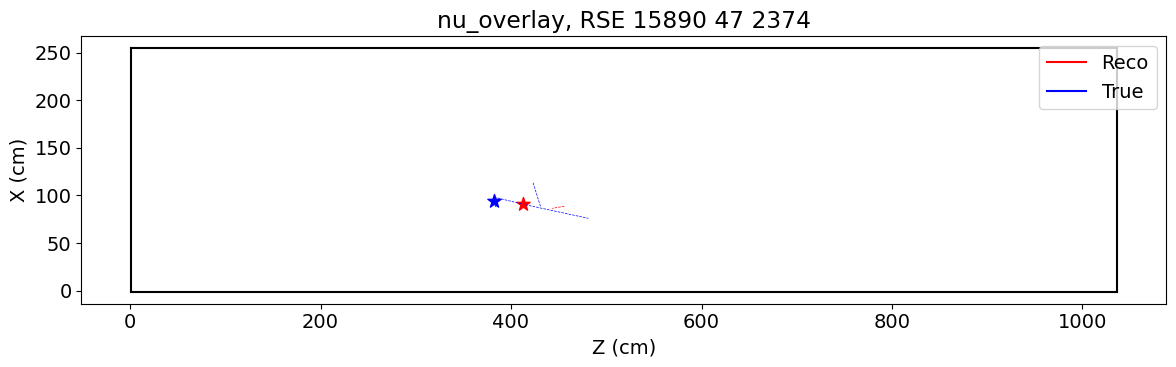

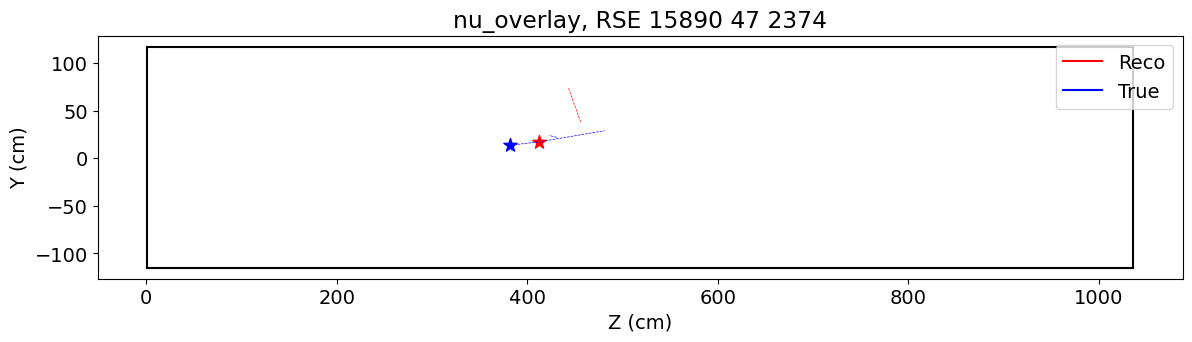

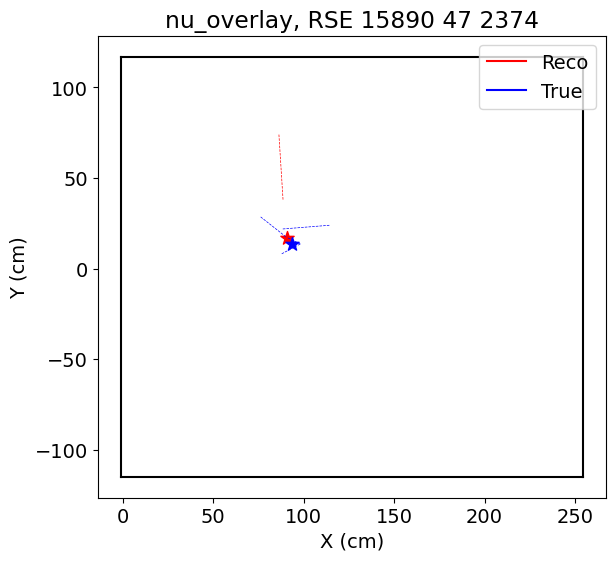

,leading_photon_energy,subleading_photon_energy
89,360.353947,81.709288


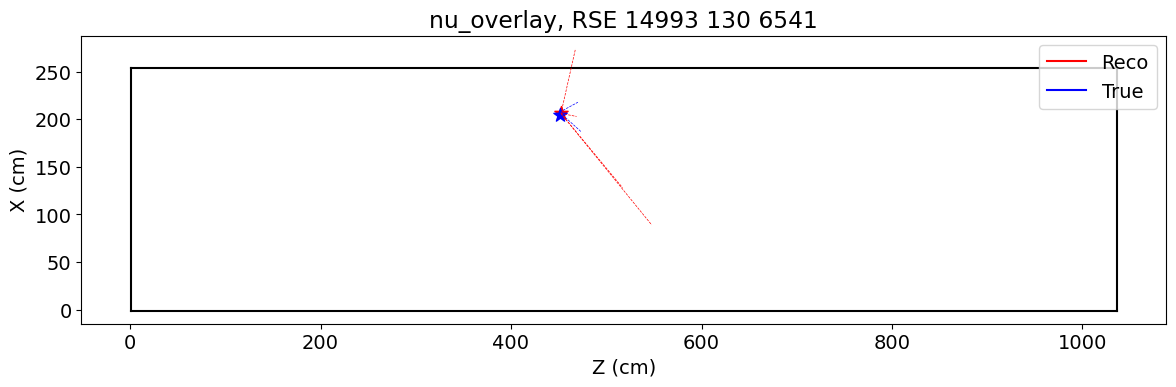

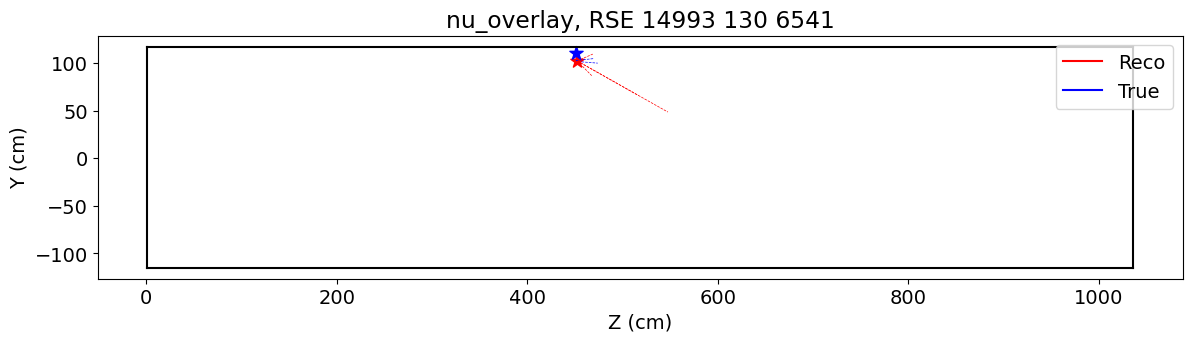

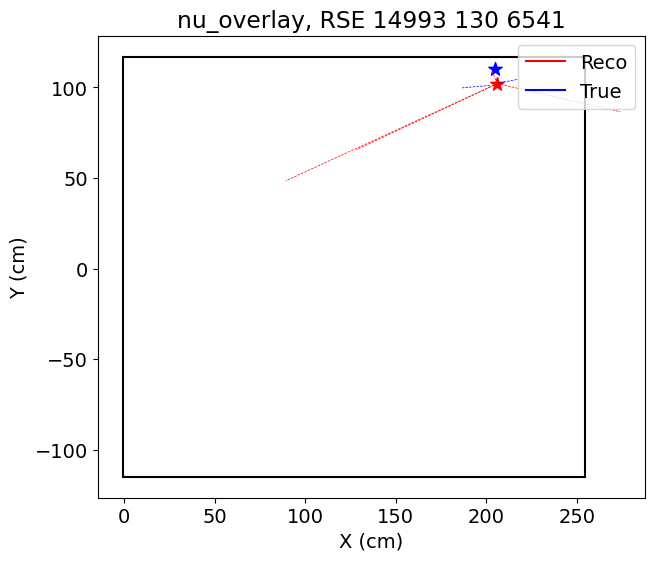

,leading_photon_energy,subleading_photon_energy
749,263.347328,59.288453


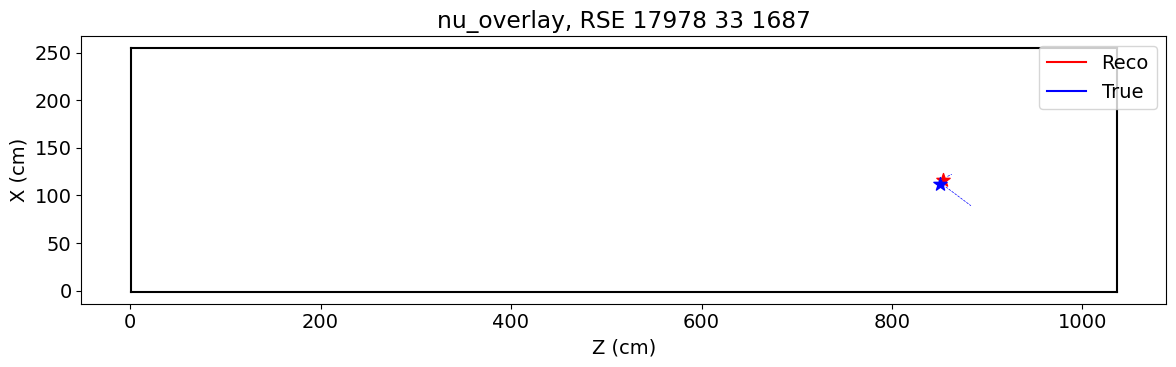

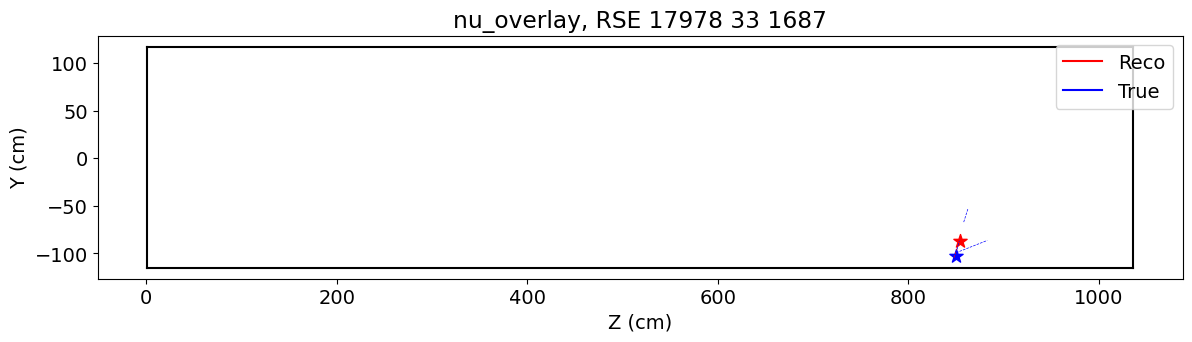

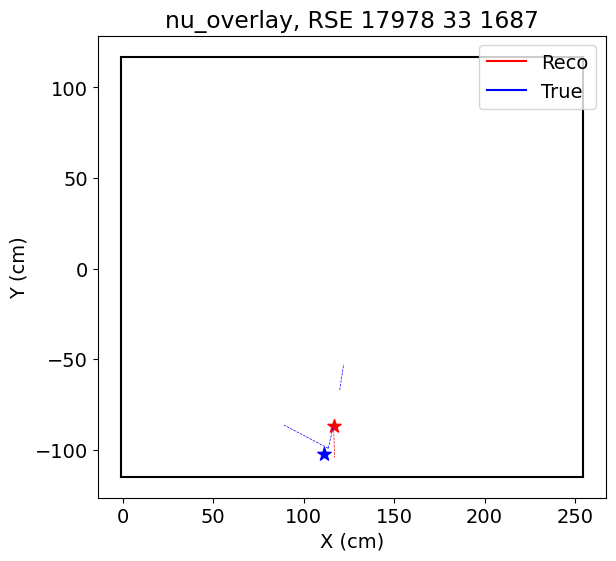

,leading_photon_energy,subleading_photon_energy
1069,465.75436,183.538243


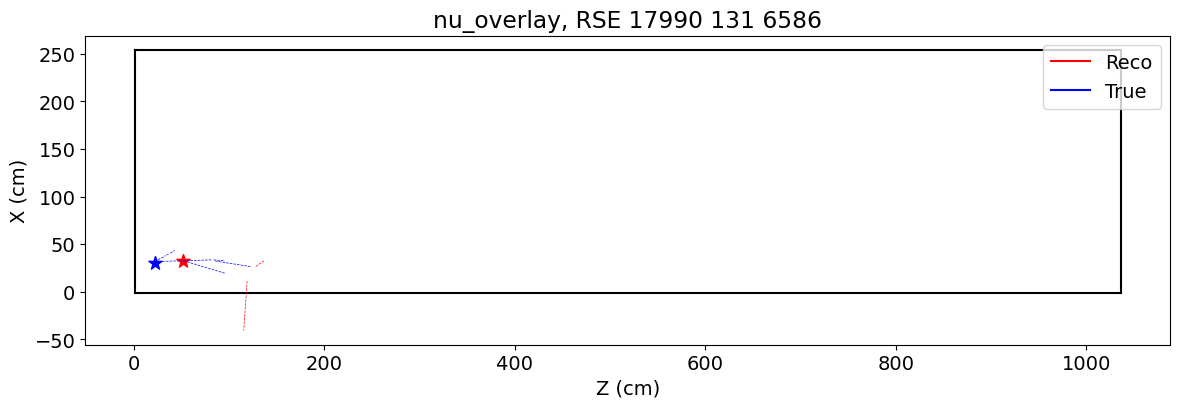

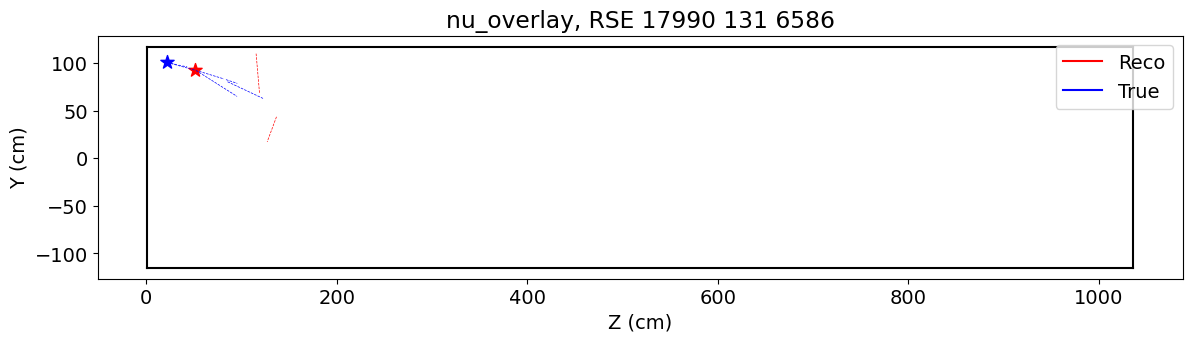

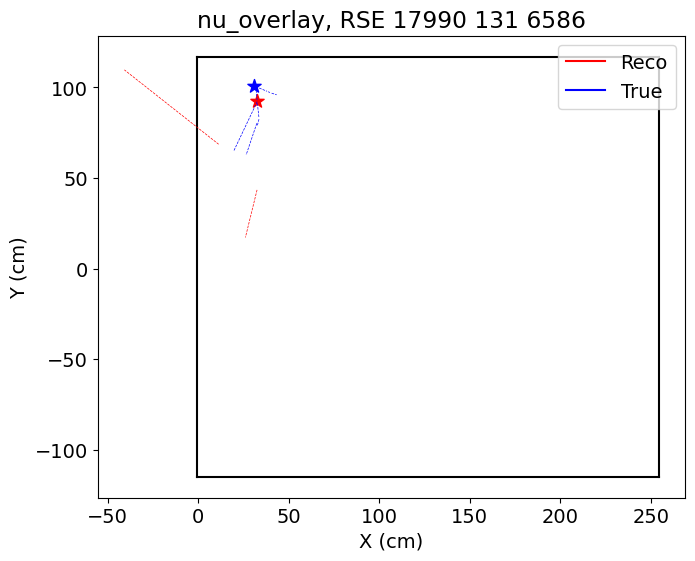

,leading_photon_energy,subleading_photon_energy
1513,201.729372,159.147307


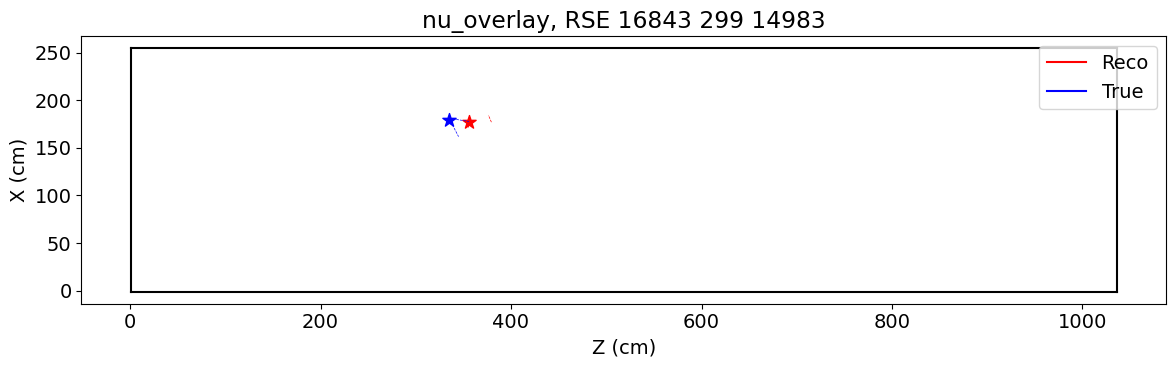

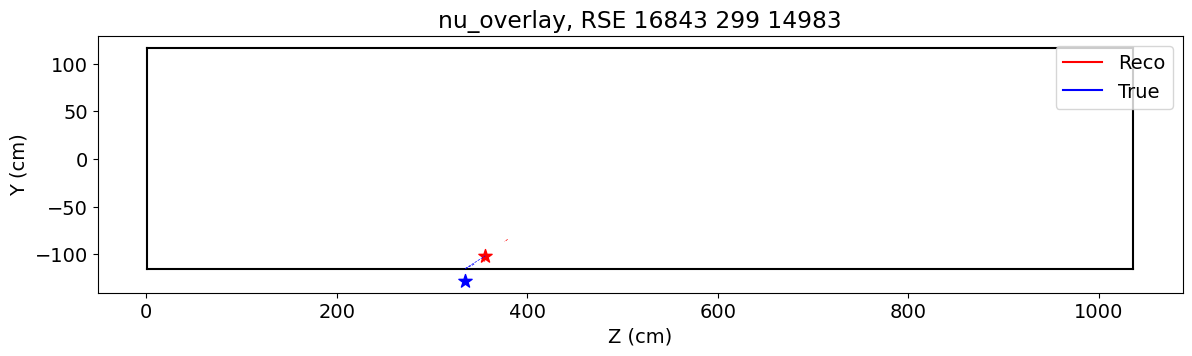

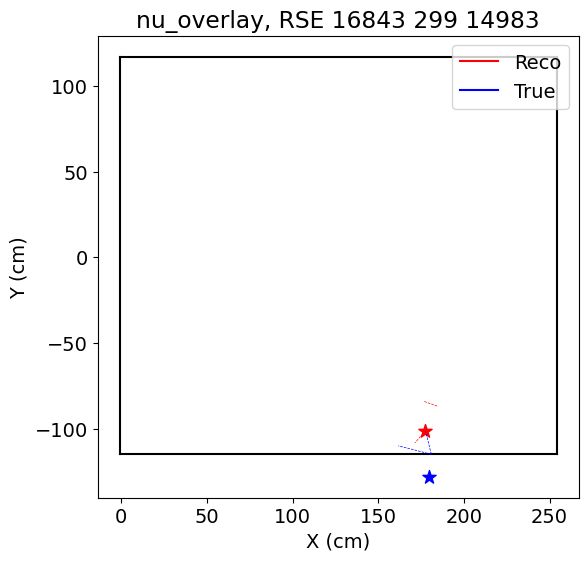

In [8]:
for i in range(5):

    one_event_df = erin_sel_1g_incomplete_both_inTPC_thresh_df.iloc[[i]]

    display(one_event_df[["leading_photon_energy", "subleading_photon_energy"]])

    show_simplified_event_display(one_event_df, view="zx", zoomed=False, show_only_photons_with_threshold=30)
    show_simplified_event_display(one_event_df, view="zy", zoomed=False, show_only_photons_with_threshold=30)
    show_simplified_event_display(one_event_df, view="xy", zoomed=False, show_only_photons_with_threshold=30)


In [10]:
with open('nc_pi0_r3_erin_sel_1g_misclustering_candidates_rse.txt', 'w') as f:
    for index, row in erin_sel_1g_incomplete_both_inTPC_thresh_df.sort_values(by=["run", "subrun", "event"]).iterrows():
        f.write(f"{row['run']} {row['subrun']} {row['event']}\n")
